In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as pyplot
import pandas as pd
import random
import plotly.express as px
from scipy.stats import t
# import sesd

In [2]:
def seasonal_mean(x, freq):
  """
  Returns the mean of the timeseries for each period in x.
  
  x    : List, array, or series containing the time series
  freq : Int that gives the number of periods per cycle (7 for week, 12 for monthly, etc)
  """
  return np.array([pd.Series(x[i::freq]).mean(skipna=True) for i in range(freq)])


def ts_S_Md_decomposition(x, freq):
  """
  Decomposes the timeseries using a modified STL method:Rx = X - Sx - X^~.
    Rx : Residuals
    X  : Original time series
    Sx : Seasonality component (average value per period)
    X^~: Median of original timeseries
    
  x    : List, array, or series containing the time series 
  freq : Int that gives the number of periods per cycle (7 for week, 12 for monthly, etc)  
  """
  nobs = len(x)
  
  # Seasonality
  period_averages = seasonal_mean(x, freq)
  seasonal = np.tile(period_averages, nobs // freq + 1)[:nobs]
  
  # Median
  med = np.tile(pd.Series(x).median(skipna=True), nobs)
  
  # Residuals
  res = np.array(x) - seasonal - med
  
  return {"observed": np.array(x), "seasonal": seasonal, "median":med, "residual":res}
  # return {"observed": np.dot(med, res, seasonal), "seasonal": seasonal, "median":med, "residual":res}


def ts_decomposition_plot(x):
  """
  Plots the timeseries decomposition for x.
  """
  fig, ax = pyplot.subplots(4, 1, sharex=True) # 4 graphs arranged in rows
  ax[0].plot(x["observed"])
  ax[0].set_ylabel("Observed")
  ax[1].plot(x["median"])
  ax[1].set_ylabel("Median")
  ax[2].plot(x["seasonal"])
  ax[2].set_ylabel("Seasonal")
  ax[3].plot(x["residual"])
  ax[3].set_ylabel("Residual")
  display(pyplot.show())
  pyplot.gcf().clear()  
  

def esd_test_statistics(x, hybrid=True):
  """
  Compute the location and dispersion sample statistics used to carry out the ESD test.
  """
  if hybrid:
    location = pd.Series(x).median(skipna=True) # Median
    dispersion = np.median(np.abs(x - np.median(x))) # Median Absolute Deviation
  else:  
    location = pd.Series(x).mean(skipna=True) # Mean
    dispersion = pd.Series(x).std(skipna=True) # Standard Deviation
    
  return location, dispersion    

def esd_test(x, freq, alpha=0.95, ub=0.499, hybrid=True):
  """
  Carries out the Extreme Studentized Deviate(ESD) test which can be used to detect one or more outliers present in the timeseries
  
  x      : List, array, or series containing the time series
  freq   : Int that gives the number of periods per cycle (7 for week, 12 for monthly, etc)
  alpha  : Confidence level in detecting outliers
  ub     : Upper bound on the fraction of datapoints which can be labeled as outliers (<=0.499)
  hybrid : Whether to use the robust statistics (median, median absolute error) or the non-robust versions (mean, standard deviation) to test for anomalies
  """
  nobs = len(x)
  if ub > 0.4999:
    ub = 0.499
  k = max(int(np.floor(ub * nobs)), 1) # Maximum number of anomalies. At least 1 anomaly must be tested.
  res_tmp_2 = ts_S_Md_decomposition(x, freq)
  ts_decomposition_plot(res_tmp_2)
  res_tmp = res_tmp_2["residual"] # Residuals from time series decomposition
    
  # Carry out the esd test k times  
  res = np.ma.array(res_tmp, mask=False) # The "ma" structure allows masking of values to exclude the elements from any calculation
  anomalies = [] # returns the indices of the found anomalies
  for i in range(1, k+1):
    location, dispersion = esd_test_statistics(res, hybrid) # Sample statistics
    tmp = np.abs(res - location) / dispersion
    idx = np.argmax(tmp) # Index of the test statistic
    test_statistic = tmp[idx] 
    n = nobs - res.mask.sum() # sums non masked values
    critical_value = (n - i) * t.ppf(alpha, n - i - 1) / np.sqrt((n - i - 1 + np.power(t.ppf(alpha, n - i - 1), 2)) * (n - i - 1)) 
    if test_statistic > critical_value:
      anomalies.append(idx)
    res.mask[idx] = True  
    
  return {"anomalies": anomalies, "seasonal": res_tmp_2["seasonal"], "median":res_tmp_2["median"], "residual":res_tmp_2["residual"], "observed":res_tmp_2["observed"]}


Data Length =  9511


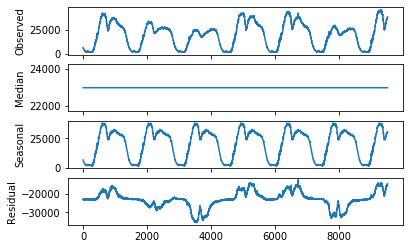

None

/home/nhantt4/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning:




<Figure size 432x288 with 0 Axes>

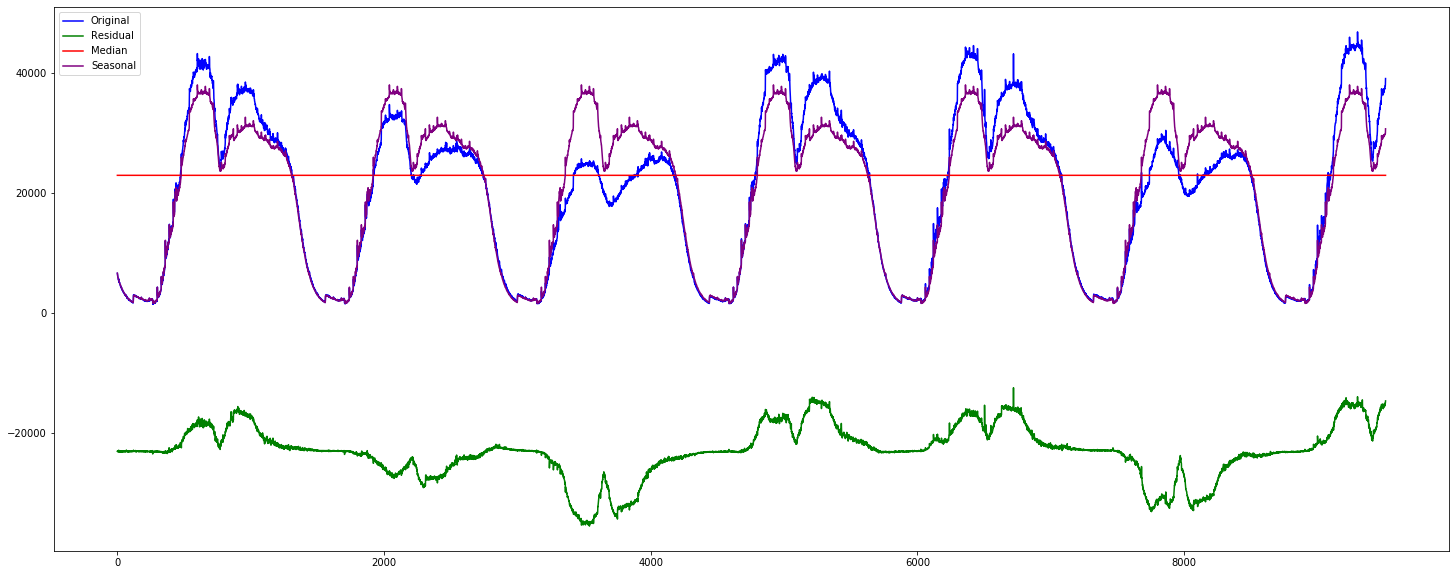

In [27]:
# cmd_1970_one_day = pd.read_csv('data.csv')
# cmd_1970_7day = pd.read_csv('1971_0_get_online_status_mobile_Success_7day')
# cmd_1970_7day = pd.read_csv('8090_Failed_7_Day')
# cmd_1970_7day = pd.read_csv('1900_Failed_7_Day')
# cmd_1970_7day = pd.read_csv('src/test/resources/data/Normal_Authen_InApp_CENTRAL')
cmd_1970_7day = pd.read_csv('src/test/resources/data/Normal_3051-PUSHOFFLINE-DELIVERED-USER_Success')
# cmd_1970_7day = pd.read_csv('send_success')
# cmd_1970_7day = pd.read_csv('getOAs')
# cmd_1970_7day = pd.read_csv('1600_Video')
# cmd_1970_7day = pd.read_csv('10003_ResizePhoto')
# cmd_1970_7day = pd.read_csv('1562_Upload')
# cmd_1970_7day = pd.read_csv('10053_GetLast_Failed')
# cmd_1970_7day = pd.read_csv('11330_Verify_Failed')
# cmd_1970_7day = pd.read_csv('1971_pcweb')

x = cmd_1970_7day['Value'].values
ts = cmd_1970_7day['TS'].values

# x[-1] = 800000
# x[-2] = 750000
# x[-3] = 700000

# for i in range(-10, 0):
#     if (i % 2 == 0):
#         x[i] = 0
#     else:
#         x[i] = 2000000
#     x[i] = 

# Z = x[-50:]
# print('Z=', Z)
    
df_len = len(x)
print('Data Length = ', df_len)

# Use the algorithm to find anomalies
anomalies = esd_test(x, 1440, alpha=0.95, ub=0.499, hybrid=True)

res = anomalies['residual']
med = anomalies['median']
obs = anomalies['observed']
sess = anomalies['seasonal']


# Plot Charts
fig, ax = pyplot.subplots()
fig.set_figwidth(25)
fig.set_figheight(10)

ax.plot(pd.Series(x).index, x, color="blue", label = "Original")
ax.plot(pd.Series(res).index, res, color="green", label = "Residual")
ax.plot(pd.Series(med).index, med, color="red", label = "Median")
ax.plot(pd.Series(sess).index, sess, color="purple", label = "Seasonal")
# ax.plot(pd.Series(subLst).index, subLst, color="purple", label = "Anomoliess")
# ax.plot(pd.Series(obs).index, obs, color="black", label = "Bbserved")
# ax.scatter(anomalies['anomalies'], x[anomalies['anomalies']], color='red', label='Anomaly')
# ax.scatter(pd.Series(outliers_indices).index, outliers_indices, color='red', label='Anomaly')
# ax.scatter(anoIndex, anoValue, color='red', label='Anomaly')

pyplot.legend(loc="best")
pyplot.show()

In [28]:
# Origin data detail
fig = px.line(x, x = ts, y = x, title='Origin data')
fig.show()

data_sess = anomalies['seasonal']
ts_residual = cmd_1970_7day['TS'].values

fig = px.line(data_sess, x = ts_residual, y = data_sess, title='Seasonal')
fig.show()

# Draw Residual Detail
data_residual = anomalies['residual']
ts_residual = cmd_1970_7day['TS'].values

fig = px.line(data_residual, x = ts_residual, y = data_residual, title='Residual')
fig.show()


sta= 659.1428571428587
median= -15686.07142857143
low= -17663.500000000007
high= -13708.642857142853
--------------------------------------------
Last Value= -14611.857142857141


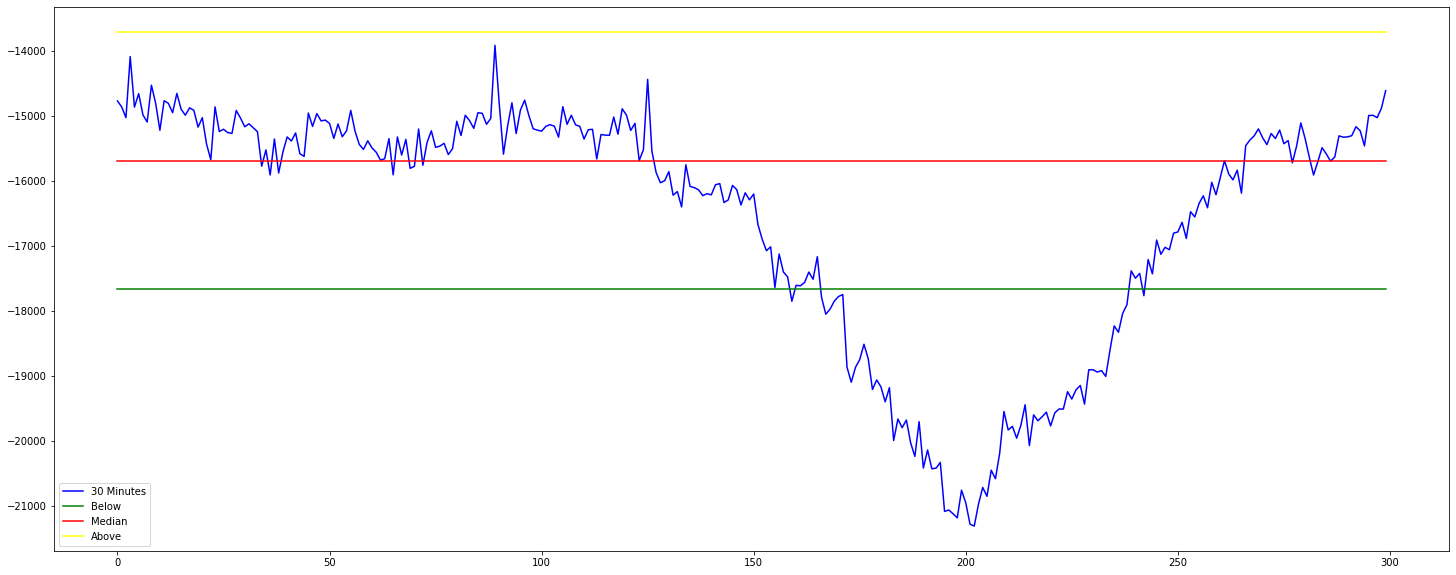

In [29]:
# Residual to check
nLastElement = -30

lenDataResidual = len(data_residual)
data_check = data_residual[nLastElement:]
ts_check = ts[nLastElement:]

# print('data_check=', data_check)

fig = px.line(data_check, x = ts_check, y = data_check, title='Residual 30 Minutes')
fig.show()

# Standard Deviation & Variance

# Residual to check
nLastElement = -300

lenDataResidual = len(data_residual)
data_check = data_residual[nLastElement:]
ts_check = ts[nLastElement:]

# sta = np.std(data_check)
# median = np.median(data_check)
median = pd.Series(data_check).median(skipna=True) # Median
sta = np.median(np.abs(data_check - np.median(data_check))) # Median Absolute Deviation

below = median - 3 * sta
above = median + 3 * sta
    

print('sta=', sta)
print('median=', median)
print('low=', below)
print('high=', above)
print('--------------------------------------------')
# print('lineCheck=', lineCheck)
lenDataCheck = len(data_check)
print('Last Value=', data_check[lenDataCheck - 1])

# print('pd.Series(median).index=', pd.Series(median).index)
# print('pd.Series(below).index=', pd.Series(below).index)

medianArr = np.full((np.abs(nLastElement)), median)
aboveArr = np.full((np.abs(nLastElement)), above)
belowArr = np.full((np.abs(nLastElement)), below)

# Plot Charts
fig, ax = pyplot.subplots()
fig.set_figwidth(25)
fig.set_figheight(10)

ax.plot(pd.Series(data_check).index, data_check, color="blue", label = "30 Minutes")
ax.plot(pd.Series(belowArr).index, belowArr, color="green", label = "Below")
ax.plot(pd.Series(medianArr).index, medianArr, color="red", label = "Median")
ax.plot(pd.Series(aboveArr).index, aboveArr, color="yellow", label = "Above")
# ax.plot(pd.Series(sess).index, sess, color="purple", label = "Seasonal")

pyplot.legend(loc="best")
pyplot.show()